In [32]:
# data science
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import datetime

# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, text as sql_text, inspect, func, text

In [33]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/meteorite-landings.sqlite")

In [34]:
# inspect to confirm existence
inspector = inspect(engine)

# Collect the names of tables within the database
tables = inspector.get_table_names()

# print metadata for each table
for table in tables:
    print(table)
    
    # get columns
    columns = inspector.get_columns(table)
    for column in columns:
        print(column["name"], column["type"])

    print()

meteorite-landings
name TEXT
id BIGINT
mass FLOAT
year FLOAT
lat FLOAT
long FLOAT
GeoLocation TEXT



### Visualizations

In [35]:
print(sqlalchemy.__version__)

2.0.31


In [36]:
# how have meteorite landings changed over the last 100 years?
# write query 
current_year = pd.Timestamp.now().year
start_year = current_year - 100
query = text(f"""
    SELECT year, COUNT(*) as count
    FROM "meteorite-landings"
    WHERE year BETWEEN :start_year AND :current_year
    GROUP BY year
    ORDER BY year;
    """)

# execute the query and make the DataFrame
with engine.connect() as connection:
    by_year_df = pd.read_sql(query, con=connection, params={"start_year": start_year, "current_year": current_year})

# show df
by_year_df.tail(10)

,year,count
80,2004.0,366
81,2005.0,328
82,2006.0,1616
83,2007.0,1038
84,2008.0,936
85,2009.0,1496
86,2010.0,1005
87,2011.0,713
88,2012.0,234
89,2013.0,11


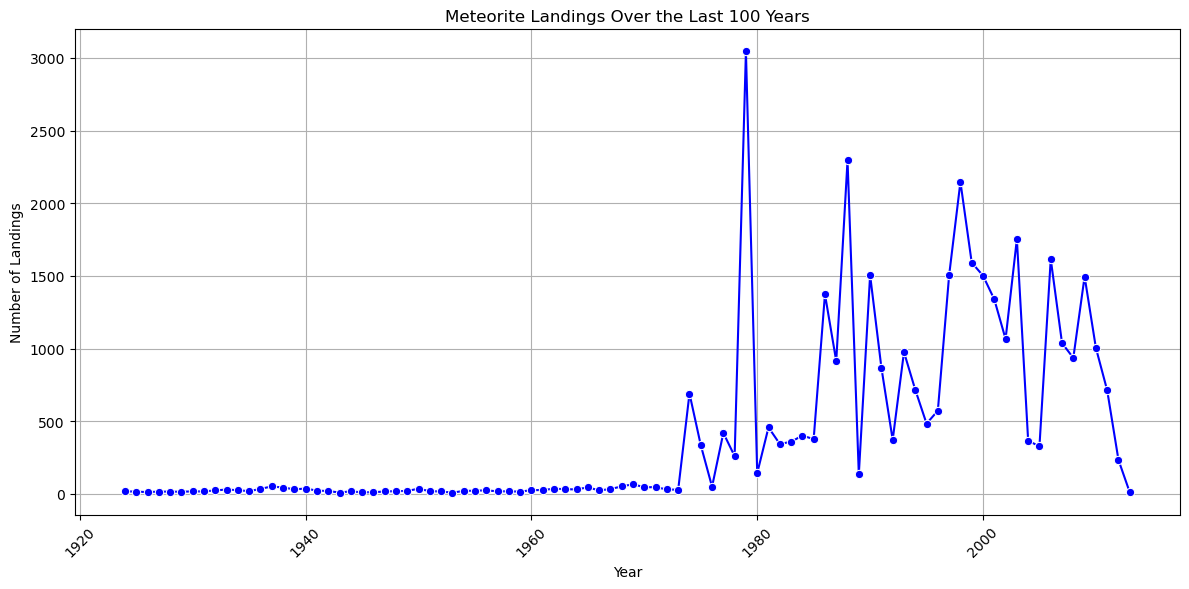

In [47]:
# create a line graph to show the data
# make the plot in seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(data=by_year_df, x='year', y='count', marker='o', color='b')

# customize
plt.title('Meteorite Landings Over the Last 100 Years')
plt.xlabel('Year')
plt.ylabel('Number of Landings')
plt.grid(True)
plt.xticks(rotation=45) 

# show
plt.tight_layout()
plt.show()

In [38]:
# is the mass of meteroties changing per year?
# create query
current_year = pd.Timestamp.now().year
start_year = current_year - 100
query = text(f"""
    SELECT year, SUM(mass) as total_mass
    FROM "meteorite-landings"
    WHERE year BETWEEN :start_year AND :current_year
    GROUP BY year
    ORDER BY year;
    """)

# execute the query and make the DataFrame
with engine.connect() as connection:
    mass_df = pd.read_sql(query, con=connection, params={"start_year": start_year, "current_year": current_year})

# show df
mass_df.head()

,year,total_mass
0,1924.0,2721322.0
1,1925.0,382737.7
2,1926.0,154623.5
3,1927.0,1205929.0
4,1928.0,136774.6


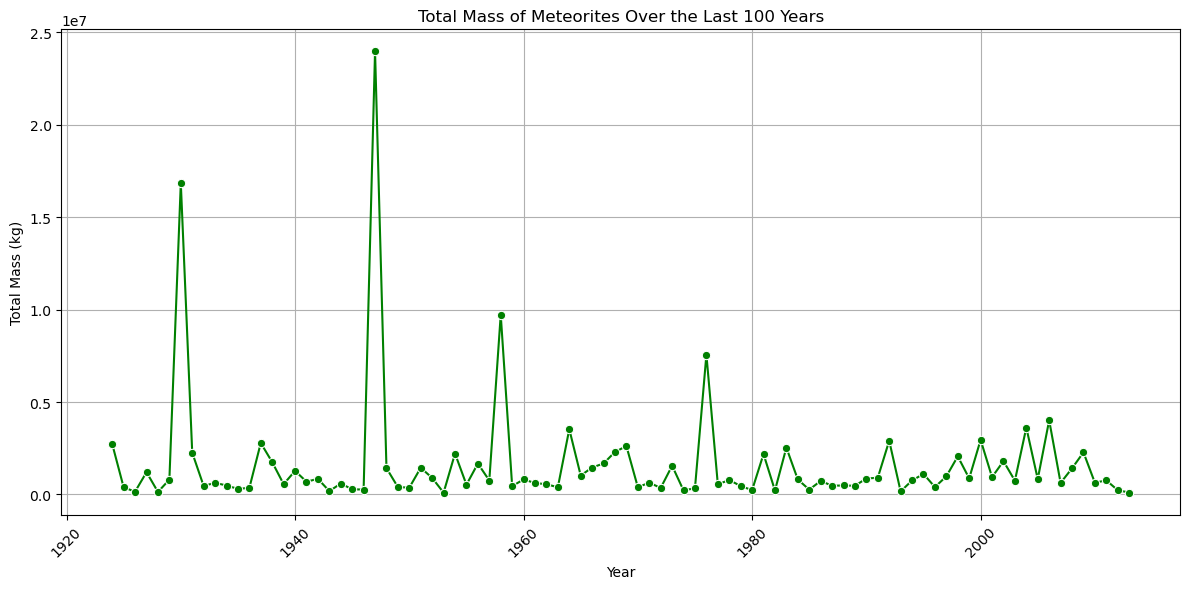

In [39]:
# create a line graph to show the data
# make the plot in seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(data=mass_df, x='year', y='total_mass', marker='o', color='g')

# customize 
plt.title('Total Mass of Meteorites Over the Last 100 Years')
plt.xlabel('Year')
plt.ylabel('Total Mass (kg)')
plt.grid(True)
plt.xticks(rotation=45) 

# Show the plot
plt.tight_layout()
plt.show()

In [40]:
# what are the top 10 largest masses
# create the query
query = text("""
    SELECT name, mass
    FROM "meteorite-landings"
    ORDER BY mass DESC
    LIMIT 10;
""")

# execute the query and make the DataFrame
with engine.connect() as connection:
    top_mass_df = pd.read_sql(query, con=connection)

# show the df
top_mass_df.head()

,name,mass
0,Hoba,60000000.0
1,Cape York,58200000.0
2,Campo del Cielo,50000000.0
3,Canyon Diablo,30000000.0
4,Armanty,28000000.0


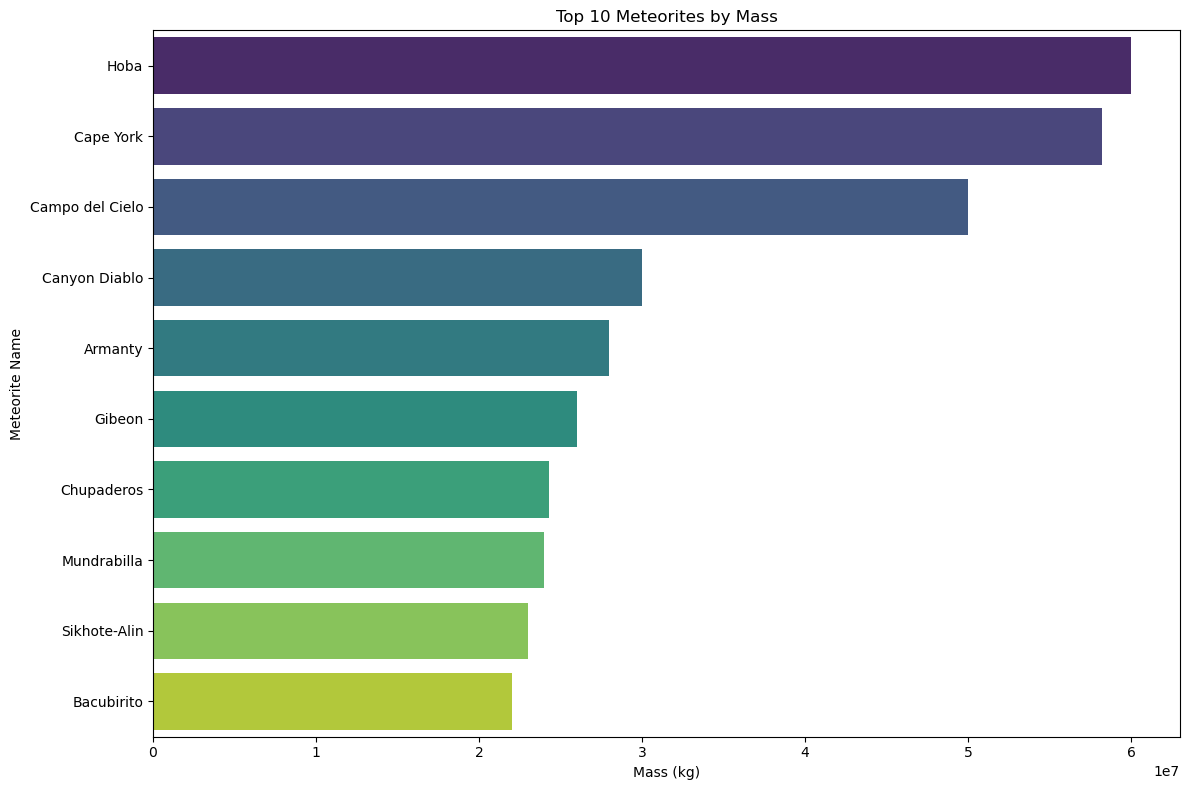

In [41]:
# use a bar plot to show the data 
# create the seaborn plot
plt.figure(figsize=(12, 8))
sns.barplot(data=top_mass_df, x='mass', y='name', palette='viridis')

# customize
plt.title('Top 10 Meteorites by Mass')
plt.xlabel('Mass (kg)')
plt.ylabel('Meteorite Name')

# show
plt.tight_layout()
plt.show()

In [42]:
# are there differences in the meteorite landings in the northern and southern hemispheres
# set the dates for the last 50 years 
current_year = pd.Timestamp.now().year
start_year = current_year - 50

# create query
query = text("""
    SELECT lat, long, mass, year
    FROM "meteorite-landings"
    WHERE year BETWEEN :start_year AND :current_year
    """)

# execute the query and make the DataFrame
with engine.connect() as connection:
    data = pd.read_sql(query, con=connection, params={"start_year": start_year, "current_year": current_year})

# group by hemisphere
north_data = data[data['lat'] >= 0]
south_data = data[data['lat'] < 0]

# add a new column to indicate the hemisphere
north_data.loc[:, 'hemisphere'] = 'Northern'
south_data.loc[:, 'hemisphere'] = 'Southern'

# Combine the data into a single DataFrame
combined_data = pd.concat([north_data, south_data])

# Group by year and hemisphere, then count occurrences
yearly_counts = combined_data.groupby(['year', 'hemisphere']).size().reset_index(name='count')

C:\Users\Kelsey\AppData\Local\Temp\ipykernel_5692\1590332792.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  north_data.loc[:, 'hemisphere'] = 'Northern'
C:\Users\Kelsey\AppData\Local\Temp\ipykernel_5692\1590332792.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  south_data.loc[:, 'hemisphere'] = 'Southern'


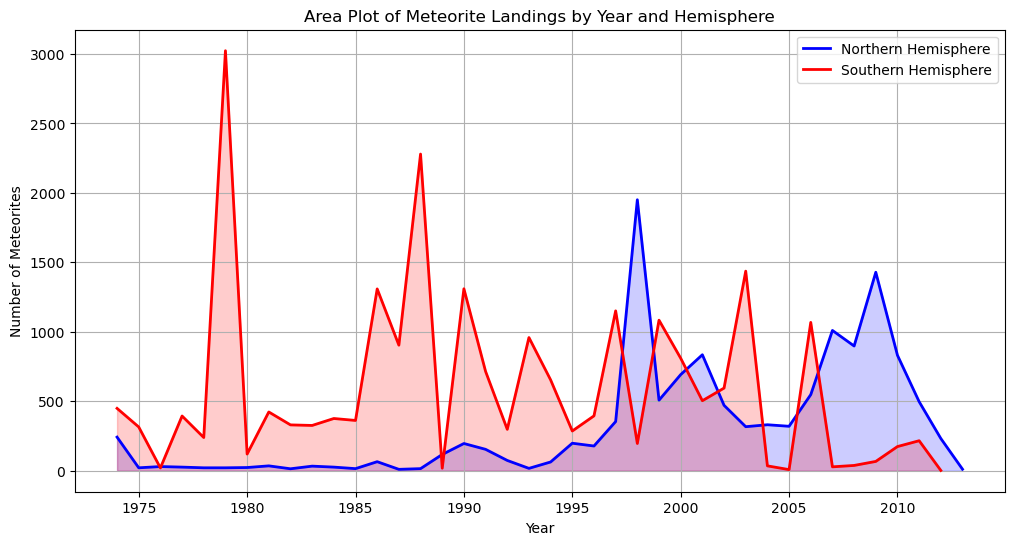

In [43]:
# create seaborn plot
plt.figure(figsize=(12, 6))

# line for northern hemisphere
sns.lineplot(data=yearly_counts[yearly_counts['hemisphere'] == 'Northern'], x='year', y='count', color='blue', label='Northern Hemisphere', linewidth=2)

# line for southern hemisphere
sns.lineplot(data=yearly_counts[yearly_counts['hemisphere'] == 'Southern'], x='year', y='count', color='red', label='Southern Hemisphere', linewidth=2)

# fill areas under the lines
plt.fill_between(yearly_counts[yearly_counts['hemisphere'] == 'Northern']['year'],
                 yearly_counts[yearly_counts['hemisphere'] == 'Northern']['count'],
                 color='blue', alpha=0.2)
plt.fill_between(yearly_counts[yearly_counts['hemisphere'] == 'Southern']['year'],
                 yearly_counts[yearly_counts['hemisphere'] == 'Southern']['count'],
                 color='red', alpha=0.2)

# customize
plt.xlabel('Year')
plt.ylabel('Number of Meteorites')
plt.title('Area Plot of Meteorite Landings by Year and Hemisphere')
plt.legend()

# show 
plt.grid(True)
plt.show()